# ***DATA LOADING AND PREPROCESSING***

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

excel_path        = "/content/drive/MyDrive/linux_data1.xlsx"
output_dir        = "/content/sample_data/nam_arb_preprocessed"
test_size         = 0.2
random_state      = 42
TOP_K_COMPONENTS  = 40

def load_and_filter(df_path):
    print("Loading raw data:", df_path)
    if df_path.endswith(".xlsx"):
        df = pd.read_excel(df_path)
    else:
        df = pd.read_csv(df_path, sep="\t", engine="python")
    print(f"  → {len(df):,} rows before filtering classes")

    df = df[df["CLASS"].isin(["NAM", "ARB"])].copy()
    print(f"  → {len(df):,} rows after filtering to NAM/ARB")
    return df

def map_labels(df):
    df["bug_type"] = df["CLASS"]
    le = LabelEncoder()
    df["label"] = le.fit_transform(df["bug_type"])
    os.makedirs(output_dir, exist_ok=True)
    joblib.dump(le, os.path.join(output_dir, "nam_arb_label_encoder.pkl"))
    print("Classes:", dict(zip(le.classes_, le.transform(le.classes_))))
    return df, le

def build_expanded(df, append_meta=True):
    texts, prods, comps, sevs, prios = [], [], [], [], []
    for _, r in df.iterrows():
        parts = []
        for c in ("summary", "description"):
            if pd.notna(r.get(c, "")):
                s = str(r[c]).strip()
                if s:
                    parts.append(s)
        txt = " ".join(parts) or "[NO_TEXT]"
        p = str(r.get("product", "")).strip()
        c = str(r.get("component", "")).strip()
        s = str(r.get("severity", "")).strip().lower() or "normal"
        pty = str(r.get("priority", "")).strip().upper() or "Other"
        if append_meta:
            tokens = []
            if p:   tokens.append(f"[PRODUCT: {p}]")
            if c:   tokens.append(f"[COMPONENT: {c}]")
            if s:   tokens.append(f"[SEVERITY: {s}]")
            if pty: tokens.append(f"[PRIORITY: {pty}]")
            if tokens:
                txt += " " + " ".join(tokens)
        texts.append(txt)
        prods.append(p or "UnknownProduct")
        comps.append(c or "Other")
        sevs.append(s)
        prios.append(pty if pty in ("P1","P2") else "Other")
    return texts, prods, comps, sevs, prios

def split_and_save(texts, prods, comps, sevs, prios, labels, label_names):
    os.makedirs(output_dir, exist_ok=True)
    df_exp = pd.DataFrame({
        "text": texts,
        "product": prods,
        "component": comps,
        "severity": sevs,
        "priority": prios,
        "label": labels,
        "label_name": label_names
    })
    X = df_exp.drop(columns=["label","label_name"])
    y = df_exp["label"]
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=random_state,
        stratify=y_temp
    )
    for split_name, X_sub, y_sub in (
        ("train", X_train, y_train),
        ("val",   X_val,   y_val),
        ("test",  X_test,  y_test),
    ):
        sub = X_sub.copy()
        sub["label"]      = y_sub.values
        sub["label_name"] = [ "NAM" if l==le.transform(["NAM"])[0] else "ARB"
                              for l in y_sub.values ]
        path = os.path.join(output_dir, f"{split_name}_data_expanded.csv")
        sub.to_csv(path, index=False)
        print(f"Saved {split_name.upper()} ({len(sub):,} rows) → {path}")
    return

def group_and_save(split):
    df = pd.read_csv(os.path.join(output_dir, f"{split}_data_expanded.csv"))
    topk = df["component"].value_counts().nlargest(TOP_K_COMPONENTS).index
    df["component_grouped"] = df["component"].where(df["component"].isin(topk), "Other")
    df["product"] = df["product"].fillna("UnknownProduct")
    cols = [
        "text",
        "product",
        "component_grouped",
        "severity",
        "priority",
        "label",
        "label_name"
    ]
    out = os.path.join(output_dir, f"{split}_data_grouped.csv")
    df[cols].to_csv(out, index=False)
    print(f"Saved grouped {split.upper()} → {out}")

if __name__ == "__main__":
    raw = load_and_filter(excel_path)
    raw, le = map_labels(raw)
    txts, prods, comps, sevs, prios = build_expanded(raw, append_meta=True)
    split_and_save(txts, prods, comps, sevs, prios,
                   raw["label"].values, raw["bug_type"].values)
    for s in ("train","val","test"):
        group_and_save(s)

    print("\n✅ Preprocessing complete.  Ready to train on the *_data_grouped.csv files.")


Loading raw data: /content/drive/MyDrive/linux_data1.xlsx
  → 4,378 rows before filtering classes
  → 1,591 rows after filtering to NAM/ARB
Classes: {'ARB': np.int64(0), 'NAM': np.int64(1)}
Saved TRAIN (1,272 rows) → /content/sample_data/nam_arb_preprocessed/train_data_expanded.csv
Saved VAL (159 rows) → /content/sample_data/nam_arb_preprocessed/val_data_expanded.csv
Saved TEST (160 rows) → /content/sample_data/nam_arb_preprocessed/test_data_expanded.csv
Saved grouped TRAIN → /content/sample_data/nam_arb_preprocessed/train_data_grouped.csv
Saved grouped VAL → /content/sample_data/nam_arb_preprocessed/val_data_grouped.csv
Saved grouped TEST → /content/sample_data/nam_arb_preprocessed/test_data_grouped.csv

✅ Preprocessing complete.  Ready to train on the *_data_grouped.csv files.


# ***PRINTING BASIC INFO ABOUT DATASET***

In [2]:
import pandas as pd

path = "/content/sample_data/nam_arb_preprocessed/train_data_grouped.csv"

df = pd.read_csv(path)

print(f"DataFrame shape = {df.shape}\n")

for col in df.columns:
    series = df[col]
    non_null = series.notna().sum()
    unique   = series.nunique(dropna=True)
    dtype    = series.dtype

    print(f"── Column: '{col}'")
    print(f"   • dtype          : {dtype}")
    print(f"   • non-null count : {non_null} / {len(df)}")
    print(f"   • unique values  : {unique}")

    if dtype == 'object' or unique <= 10:
        print("   • Top values:")
        vc = series.value_counts(dropna=False).head(10)
        for val, cnt in vc.items():
            print(f"       {repr(val):<20} : {cnt}")
    else:
        desc = series.describe().to_dict()
        print("   • Summary stats:")
        for stat in ["mean","std","min","25%","50%","75%","max"]:
            if stat in desc:
                print(f"       {stat:<6} : {desc[stat]}")
    print()


DataFrame shape = (1272, 7)

── Column: 'text'
   • dtype          : object
   • non-null count : 1272 / 1272
   • unique values  : 1272
   • Top values:
       "snd_hda_intel is oopsing on Asus A8N-VM CSM onboard chipset Most recent kernel where this bug did not occur: the card was not working before Distribution: Mandriva cooker Hardware Environment: this is a Asus A8N-VM CSM mother board, with a onboard sound chipset ( ADI AD1986A ), and a pci sound card ( sb 128 ), that i do not use at the moment. $ cat /proc/cpuinfo processor : 0 vendor_id : AuthenticAMD cpu family : 15 model : 31 model name : AMD Athlon(tm) 64 Processor 3200+ stepping : 0 cpu MHz : 1000.000 cache size : 512 KB fpu : yes fpu_exception : yes cpuid level : 1 wp : yes flags : fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 syscall nx mmxext fxsr_opt lm 3dnowext 3dnow lahf_lm bogomips : 2012.70 TLB size : 1024 4K pages clflush size : 64 cache_alignment : 64 address siz

# ***FINAL MODEL TRAINING AND EVALUATION***

ARB/NAM Classification with Text + Metadata
---------------------------------------------------------------------------
DATA_DIR                 : /content/sample_data/nam_arb_preprocessed
MODEL_NAME_OR_PATH       : /content/drive/MyDrive/sem_model_4
TRAIN_FILE               : train_data_grouped.csv
VAL_FILE                 : val_data_grouped.csv
TEST_FILE                : test_data_grouped.csv
LABEL_ENCODER_FILE       : nam_arb_label_encoder.pkl
MAX_LENGTH               : 256
BATCH_SIZE               : 8
LEARNING_RATE            : 2e-05
WEIGHT_DECAY             : 0.01
EPOCHS                   : 7
DEVICE                   : cuda
PATIENCE                 : 3
SAVE_MODEL               : True
GRADIENT_ACCUMULATION_STEPS: 2
OUTPUT_MODEL_DIR         : /content/nam_arb_classifier_with_meta
USE_WEIGHTED_SAMPLING    : True
TRAIN_ON_COMBINED_DATA   : True
NUM_WORKERS              : 0
MAX_GRAD_NORM            : 1.0
WARMUP_RATIO             : 0.1
---------------------------------------------------

Epoch 1: Train Loss: 2.0701, Val Loss: 0.6348
           Train Acc: 0.5779, Val Acc: 0.6101, Val F1 (W): 0.6741
  ARB Val F1: 0.3673
  NAM Val F1: 0.7182
   New best Val F1 (W): 0.6741. Model saved.


Epoch 2: Train Loss: 0.4115, Val Loss: 0.2399
           Train Acc: 0.7980, Val Acc: 0.8931, Val F1 (W): 0.9024
  ARB Val F1: 0.6667
  NAM Val F1: 0.9363
   New best Val F1 (W): 0.9024. Model saved.


Epoch 3: Train Loss: 0.2498, Val Loss: 0.0906
           Train Acc: 0.8889, Val Acc: 0.9874, Val F1 (W): 0.9874
  ARB Val F1: 0.9500
  NAM Val F1: 0.9928
   New best Val F1 (W): 0.9874. Model saved.


Epoch 4: Train Loss: 0.1552, Val Loss: 0.0727
           Train Acc: 0.9434, Val Acc: 0.9686, Val F1 (W): 0.9700
  ARB Val F1: 0.8889
  NAM Val F1: 0.9817


Epoch 5: Train Loss: 0.0832, Val Loss: 0.0730
           Train Acc: 0.9658, Val Acc: 0.9811, Val F1 (W): 0.9817
  ARB Val F1: 0.9302
  NAM Val F1: 0.9891


Epoch 6: Train Loss: 0.0601, Val Loss: 0.0319
           Train Acc: 0.9790, Val Acc: 0.9937, Val F1 (W): 0.9938
  ARB Val F1: 0.9756
  NAM Val F1: 0.9964
   New best Val F1 (W): 0.9938. Model saved.


Epoch 7: Train Loss: 0.0630, Val Loss: 0.0127
           Train Acc: 0.9825, Val Acc: 1.0000, Val F1 (W): 1.0000
  ARB Val F1: 1.0000
  NAM Val F1: 1.0000
   New best Val F1 (W): 1.0000. Model saved.
Loaded best model weights from 'best_model_temp.pth'
Training history plot saved to /content/arb_nam_training_history.png


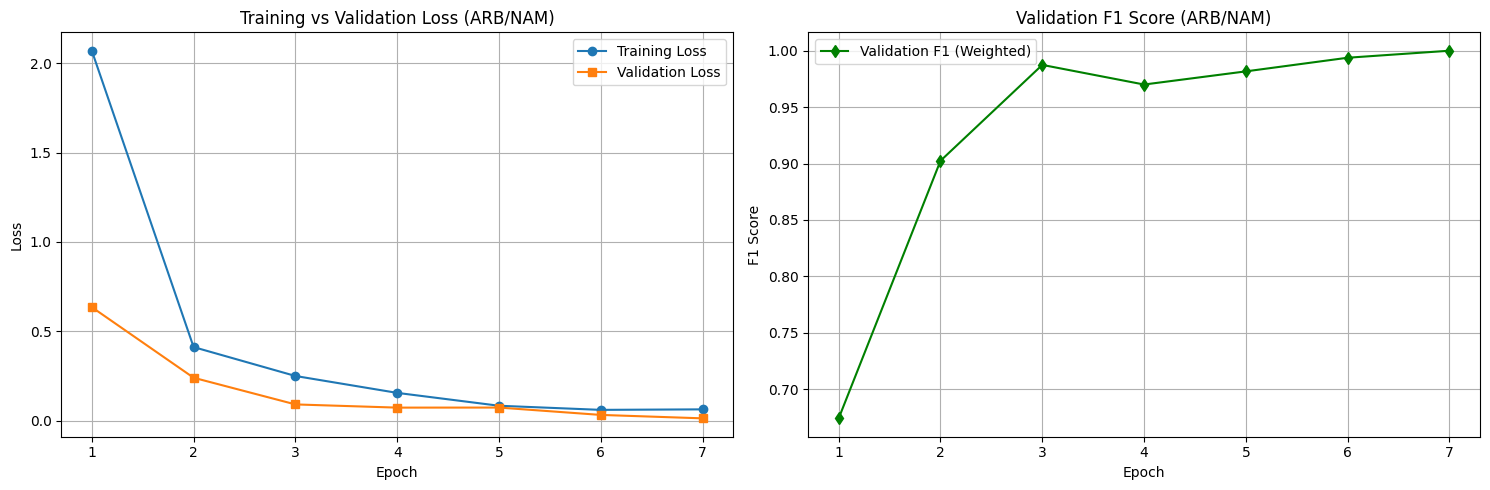


Final Model Evaluation on Test Set


Evaluating Final Model: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s]



Final Model Evaluation Classification Report:
              precision    recall  f1-score   support

         ARB       0.58      0.52      0.55        21
         NAM       0.93      0.94      0.94       139

    accuracy                           0.89       160
   macro avg       0.75      0.73      0.74       160
weighted avg       0.88      0.89      0.89       160

Saved fine-tuned model and tokenizer to /content/nam_arb_classifier_with_meta

FINAL RESULTS
Best Validation F1 (Weighted): 1.0000
Test Accuracy       : 0.8875
Test Precision (W)  : 0.8831
Test Recall (W)     : 0.8875
Test F1 (Weighted)  : 0.8851

Final GPU Memory Status:
GPU Available: Tesla T4
GPU Memory Total: 14.7 GB
Currently Allocated: 0.0 GB
Currently Cached (Reserved): 0.4 GB


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import joblib
from collections import Counter
import os
import gc
import random
from torch.nn.utils import clip_grad_norm_
import traceback

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

def check_gpu_info():
    if torch.cuda.is_available():
        print(f"GPU Available: {torch.cuda.get_device_name(0)}")
        try:
            total_memory = torch.cuda.get_device_properties(0).total_memory
            allocated_memory = torch.cuda.memory_allocated(0)
            reserved_memory = torch.cuda.memory_reserved(0)
            print(f"GPU Memory Total: {total_memory / 1024**3:.1f} GB")
            print(f"Currently Allocated: {allocated_memory / 1024**3:.1f} GB")
            print(f"Currently Cached (Reserved): {reserved_memory / 1024**3:.1f} GB")
        except Exception as e:
            print(f"Could not get detailed GPU memory info: {e}")
    else:
        print("GPU not available, using CPU")

CONFIG = {
    'DATA_DIR': '/content/sample_data/nam_arb_preprocessed',
    'MODEL_NAME_OR_PATH': '/content/drive/MyDrive/sem_model_4',
    'TRAIN_FILE': 'train_data_grouped.csv',
    'VAL_FILE': 'val_data_grouped.csv',
    'TEST_FILE': 'test_data_grouped.csv',
    'LABEL_ENCODER_FILE': 'nam_arb_label_encoder.pkl',
    'MAX_LENGTH': 256,
    'BATCH_SIZE': 8,
    'LEARNING_RATE': 2e-5,
    'WEIGHT_DECAY': 0.01,
    'EPOCHS': 7,
    'DEVICE': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'PATIENCE': 3,
    'SAVE_MODEL': True,
    'GRADIENT_ACCUMULATION_STEPS': 2,
    'OUTPUT_MODEL_DIR': '/content/nam_arb_classifier_with_meta',
    'USE_WEIGHTED_SAMPLING': True,
    'TRAIN_ON_COMBINED_DATA': True,
    'NUM_WORKERS': 0,
    'MAX_GRAD_NORM': 1.0,
    'WARMUP_RATIO': 0.1,
}

class ARBNAMTextWithMetaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = str(row['text']).strip()
        if not text:
            text = "[EMPTY]"

        has_metadata_tokens = any(token in text for token in ['[PRODUCT:', '[COMPONENT:', '[SEVERITY:', '[PRIORITY:'])

        if not has_metadata_tokens:
            meta_tokens = []
            for col, token_name in [('product', 'PRODUCT'),
                                   ('component_grouped', 'COMPONENT'),
                                   ('severity', 'SEVERITY'),
                                   ('priority', 'PRIORITY')]:
                val = row.get(col, "")
                if isinstance(val, float) and np.isnan(val):
                    continue
                val_str = str(val).strip()
                if val_str and val_str.lower() not in ['nan', 'none', 'unknownproduct']:
                    token = f"[{token_name}: {val_str}]"
                    meta_tokens.append(token)

            if meta_tokens:
                text = text + " " + " ".join(meta_tokens)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        label = torch.tensor(row['label'], dtype=torch.long)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

def load_arb_nam_data():
    print("Loading ARB/NAM data...")
    data_dir = CONFIG['DATA_DIR']
    try:
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"Data directory not found: {data_dir}")

        train_csv = os.path.join(data_dir, CONFIG['TRAIN_FILE'])
        val_csv = os.path.join(data_dir, CONFIG['VAL_FILE'])
        test_csv = os.path.join(data_dir, CONFIG['TEST_FILE'])

        if not os.path.exists(train_csv):
            raise FileNotFoundError(f"Train file not found: {train_csv}")
        if not os.path.exists(val_csv):
            raise FileNotFoundError(f"Val file not found: {val_csv}")
        if not os.path.exists(test_csv):
            raise FileNotFoundError(f"Test file not found: {test_csv}")

        train_df = pd.read_csv(train_csv)
        val_df = pd.read_csv(val_csv)
        test_df = pd.read_csv(test_csv)

        le_path = os.path.join(data_dir, CONFIG['LABEL_ENCODER_FILE'])
        if os.path.exists(le_path):
            try:
                label_encoder = joblib.load(le_path)
                print(f"Loaded existing label encoder from {le_path}")
                print(f"Label encoder classes: {label_encoder.classes_}")
            except Exception as e:
                print(f"Failed to load label encoder at {le_path}: {e}")
                print("Will create a new LabelEncoder from train_df['label_name'].")
                label_encoder = None
        else:
            print(f"{CONFIG['LABEL_ENCODER_FILE']} not found at {le_path}. Creating a new one.")
            label_encoder = None

        for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
            print(f"{name} - rows before cleaning: {len(df)}; missing text: {df['text'].isna().sum()}")
            df['text'] = df['text'].fillna("[EMPTY_NAN]").astype(str).str.strip()
            df.dropna(subset=['label'], inplace=True)
            print(f"{name} - rows after cleaning: {len(df)}")

        if label_encoder is None:
            from sklearn.preprocessing import LabelEncoder
            label_encoder = LabelEncoder()
            unique_labels = train_df['label_name'].astype(str).unique().tolist()
            label_encoder.fit(unique_labels)
            try:
                joblib.dump(label_encoder, le_path)
                print(f"Saved new label encoder to {le_path}")
            except Exception as e:
                print(f"Failed to save new label encoder to {le_path}: {e}")

        print(f"\nData Loaded - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
        print("Train label distribution (label_name counts):")
        print(train_df['label_name'].value_counts())
        print("Train label distribution (numeric label counts):")
        print(train_df['label'].value_counts())

        if train_df['label_name'].nunique() > 1:
            ratio = train_df['label_name'].value_counts().min() / train_df['label_name'].value_counts().max()
            print(f"Class balance ratio (min/max) = {ratio:.3f}")

        return train_df, val_df, test_df, label_encoder

    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def train_fold_with_accumulation(model, train_loader, val_loader, optimizer, scheduler, epochs, patience, label_encoder_obj):
    best_val_f1 = 0.0
    patience_counter = 0
    target_names = list(label_encoder_obj.classes_)
    train_losses, val_losses, val_f1_scores = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        train_correct = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} Training', leave=False)
        for batch_idx, batch in enumerate(progress_bar):
            if batch_idx % CONFIG['GRADIENT_ACCUMULATION_STEPS'] == 0:
                optimizer.zero_grad(set_to_none=True if CONFIG['DEVICE'].type == 'cuda' else False)

            input_ids = batch['input_ids'].to(CONFIG['DEVICE'])
            attention_mask = batch['attention_mask'].to(CONFIG['DEVICE'])
            labels = batch['labels'].to(CONFIG['DEVICE'])

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss = loss / CONFIG['GRADIENT_ACCUMULATION_STEPS']
            loss.backward()

            train_loss_epoch += loss.item() * CONFIG['GRADIENT_ACCUMULATION_STEPS']
            preds = outputs.logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

            if (batch_idx + 1) % CONFIG['GRADIENT_ACCUMULATION_STEPS'] == 0:
                clip_grad_norm_(model.parameters(), CONFIG['MAX_GRAD_NORM'])
                optimizer.step()
                if scheduler:
                    scheduler.step()

            current_loss = loss.item() * CONFIG['GRADIENT_ACCUMULATION_STEPS']
            progress_bar.set_postfix({'loss': f'{current_loss:.4f}'})

            if batch_idx > 0 and batch_idx % 100 == 0:
                clear_gpu_memory()

        if len(train_loader) % CONFIG['GRADIENT_ACCUMULATION_STEPS'] != 0:
            clip_grad_norm_(model.parameters(), CONFIG['MAX_GRAD_NORM'])
            optimizer.step()
            optimizer.zero_grad(set_to_none=True if CONFIG['DEVICE'].type == 'cuda' else False)

        avg_train_loss = train_loss_epoch / len(train_loader)
        train_accuracy = train_correct / total_train if total_train > 0 else 0.0

        model.eval()
        val_loss_epoch = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} Validation', leave=False):
                input_ids = batch['input_ids'].to(CONFIG['DEVICE'])
                attention_mask = batch['attention_mask'].to(CONFIG['DEVICE'])
                labels = batch['labels'].to(CONFIG['DEVICE'])

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss_epoch += outputs.loss.item()
                preds = outputs.logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss_epoch / len(val_loader)
        val_report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True, zero_division=0)
        val_acc_epoch = val_report['accuracy']
        val_f1_epoch = val_report['weighted avg']['f1-score']

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1_epoch)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'           Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc_epoch:.4f}, Val F1 (W): {val_f1_epoch:.4f}')
        for cname in target_names:
            if cname in val_report and isinstance(val_report[cname], dict):
                print(f'  {cname} Val F1: {val_report[cname]["f1-score"]:.4f}')

        if val_f1_epoch > best_val_f1:
            best_val_f1 = val_f1_epoch
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_temp.pth')
            print(f"   New best Val F1 (W): {best_val_f1:.4f}. Model saved.")
        else:
            patience_counter += 1

        if patience_counter >= CONFIG['PATIENCE']:
            print(f"   Early stopping at epoch {epoch+1}. No improvement for {CONFIG['PATIENCE']} epochs.")
            break

        clear_gpu_memory()

    if os.path.exists('best_model_temp.pth'):
        model.load_state_dict(torch.load('best_model_temp.pth'))
        print("Loaded best model weights from 'best_model_temp.pth'")
    else:
        print("No 'best_model_temp.pth' found; using last epoch weights.")

    return best_val_f1, train_losses, val_losses, val_f1_scores

def evaluate_final_model(model, data_loader, device, label_encoder_obj):
    model.eval()
    all_preds, all_labels = [], []
    target_names = list(label_encoder_obj.classes_)

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Final Model"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nFinal Model Evaluation Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    return acc, prec, rec, f1

def plot_training_history(train_losses, val_losses, val_f1_scores, save_path='/content/arb_nam_training_history.png'):
    epochs_ran = range(1, len(train_losses) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs_ran, train_losses, label='Training Loss', marker='o')
    ax1.plot(epochs_ran, val_losses, label='Validation Loss', marker='s')
    ax1.set_title('Training vs Validation Loss (ARB/NAM)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs_ran, val_f1_scores, label='Validation F1 (Weighted)', marker='d', color='green')
    ax2.set_title('Validation F1 Score (ARB/NAM)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Training history plot saved to {save_path}")
    plt.show()

def fine_tune_and_evaluate(original_train_df, original_val_df, test_df, label_encoder_obj):
    print("Starting ARB/NAM fine-tuning with metadata integration...")

    if CONFIG['TRAIN_ON_COMBINED_DATA']:
        print("Combining train_df + val_df for training set.")
        train_df_for_training = pd.concat([original_train_df, original_val_df], ignore_index=True)
        val_df_for_validation = original_val_df.copy()
    else:
        print("Using only train_df for training; val_df for validation.")
        train_df_for_training = original_train_df.copy()
        val_df_for_validation = original_val_df.copy()

    num_classes = len(label_encoder_obj.classes_)
    print(f"Number of classes = {num_classes}")
    print(f"Classes: {label_encoder_obj.classes_}")
    print("Training examples:", len(train_df_for_training),
          "| Validation examples:", len(val_df_for_validation),
          "| Test examples:", len(test_df))
    print("Train label distribution:", Counter(train_df_for_training['label']))

    tokenizer = AutoTokenizer.from_pretrained(CONFIG['MODEL_NAME_OR_PATH'])

    train_dataset = ARBNAMTextWithMetaDataset(train_df_for_training, tokenizer, CONFIG['MAX_LENGTH'])
    val_dataset = ARBNAMTextWithMetaDataset(val_df_for_validation, tokenizer, CONFIG['MAX_LENGTH'])
    test_dataset = ARBNAMTextWithMetaDataset(test_df, tokenizer, CONFIG['MAX_LENGTH'])

    train_labels = list(train_df_for_training['label'])
    train_sampler = None
    shuffle_flag = True
    if CONFIG['USE_WEIGHTED_SAMPLING'] and len(train_labels) > 0:
        class_counts = Counter(train_labels)
        label_list = list(range(num_classes))
        counts_arr = np.array([class_counts.get(lbl, 0) for lbl in label_list], dtype=float)
        if np.any(counts_arr == 0):
            weights = 1.0 / (counts_arr + 1e-6)
        else:
            weights = 1.0 / counts_arr

        sample_weights = np.array([weights[lbl] for lbl in train_labels], dtype=float)
        sample_weights = torch.from_numpy(sample_weights).double()
        train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
        shuffle_flag = False
        print(f"WeightedRandomSampler enabled. Class counts: {class_counts}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        sampler=train_sampler,
        shuffle=shuffle_flag,
        num_workers=CONFIG['NUM_WORKERS'],
        pin_memory=True
    )
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'] * 2, shuffle=False,
                            num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'] * 2, shuffle=False,
                             num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG['MODEL_NAME_OR_PATH'],
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    ).to(CONFIG['DEVICE'])

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
            'weight_decay': CONFIG['WEIGHT_DECAY']
        },
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=CONFIG['LEARNING_RATE'])

    steps_per_epoch = len(train_loader) // CONFIG['GRADIENT_ACCUMULATION_STEPS']
    if len(train_loader) % CONFIG['GRADIENT_ACCUMULATION_STEPS'] != 0:
        steps_per_epoch += 1
    total_training_steps = steps_per_epoch * CONFIG['EPOCHS']
    warmup_steps = int(total_training_steps * CONFIG['WARMUP_RATIO'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_training_steps
    )
    print(f"Total training steps: {total_training_steps}, Warmup steps: {warmup_steps}")

    best_val_f1, train_losses, val_losses, val_f1_scores = train_fold_with_accumulation(
        model, train_loader, val_loader, optimizer, scheduler,
        CONFIG['EPOCHS'], CONFIG['PATIENCE'], label_encoder_obj
    )

    if train_losses:
        plot_training_history(train_losses, val_losses, val_f1_scores)

    print(f"\nFinal Model Evaluation on Test Set")
    test_acc, test_prec, test_rec, test_f1 = evaluate_final_model(model, test_loader, CONFIG['DEVICE'], label_encoder_obj)

    if CONFIG['SAVE_MODEL']:
        out_dir = CONFIG['OUTPUT_MODEL_DIR']
        os.makedirs(out_dir, exist_ok=True)
        model.save_pretrained(out_dir)
        tokenizer.save_pretrained(out_dir)
        joblib.dump(label_encoder_obj, os.path.join(out_dir, 'label_encoder.pkl'))
        print(f"Saved fine-tuned model and tokenizer to {out_dir}")

    if os.path.exists('best_model_temp.pth'):
        os.remove('best_model_temp.pth')

    return test_acc, test_prec, test_rec, test_f1, best_val_f1

def main():
    print("ARB/NAM Classification with Text + Metadata")
    print("-" * 75)
    for k, v in CONFIG.items():
        print(f"{k:25}: {v}")
    print("-" * 75)
    check_gpu_info()

    try:
        train_df, val_df, test_df, label_encoder = load_arb_nam_data()
        results = fine_tune_and_evaluate(train_df, val_df, test_df, label_encoder)

        if results and results[0] is not None:
            test_acc, test_prec, test_rec, test_f1, best_val_f1 = results
            print(f"\nFINAL RESULTS")
            print(f"Best Validation F1 (Weighted): {best_val_f1:.4f}")
            print(f"Test Accuracy       : {test_acc:.4f}")
            print(f"Test Precision (W)  : {test_prec:.4f}")
            print(f"Test Recall (W)     : {test_rec:.4f}")
            print(f"Test F1 (Weighted)  : {test_f1:.4f}")
        else:
            print("Training/evaluation did not produce valid results.")

        if torch.cuda.is_available():
            print("\nFinal GPU Memory Status:")
            check_gpu_info()

    except Exception as e:
        print(f"Main execution error: {e}")
        traceback.print_exc()
    finally:
        clear_gpu_memory()

if __name__ == "__main__":
    main()